In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn import preprocessing

import time
import matplotlib.pyplot as plt
from numpy import newaxis

def load_data(data_path,P,step):
    num_logs = P+step
    df = pd.read_csv(data_path)
    

    data_np = np.zeros((len(df),num_logs))
    data_df_combined = pd.DataFrame(data_np)
    data_df_combined.loc[:,0] = df['SYSLoad'].values

    for i in range(1, num_logs):
        data_df_combined.loc[:,i] = data_df_combined.shift(-i)

    data_df_combined_clean = data_df_combined.dropna()
    data_df_combined_clean = data_df_combined_clean.reset_index()
    data_df_combined_clean.drop('index',axis=1,inplace=True)
    data_combined_standardized = preprocessing.scale(data_df_combined_clean)

    train_split = round(0.8 * data_combined_standardized.shape[0])
    val_split = round(0.9 * data_combined_standardized.shape[0])
    #print("all len",data_combined_standardized.shape[0])
    #print("train_split",train_split)

    X = data_combined_standardized[:,:P]
    Y = data_combined_standardized[:,P:]

    X_train = X[:train_split]
    Y_train = Y[:train_split]
    X_test = X[train_split:]
    Y_test = Y[train_split:]

    X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
    Y_train = Y_train.reshape((Y_train.shape[0],Y_train.shape[1],1))
    X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))
    Y_test = Y_test.reshape((Y_test.shape[0],Y_test.shape[1],1))

    return X_train,Y_train,X_test,Y_test,data_df_combined_clean


In [ ]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

use_cuda = torch.cuda.is_available()

class TorchDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.x)

class TorchDataLoader:
    def __init__(self,batch_size,shuffle = True):
        self.batch_size = batch_size
        self.shuffle = shuffle
    
    def torch_dataloader(self,train_data,target_data):
        torch_dataset = TorchDataset(train_data,target_data)
        torch_loader = DataLoader(dataset = torch_dataset,
                                batch_size = self.batch_size, 
                                shuffle = self.shuffle)
        return torch_loader

def plot_results(predicted_data, true_data):
    # use in train.py 
    # plot evaluate result
    fig = plt.figure(facecolor='white', figsize=(12, 6))
    ax = fig.add_subplot(111)
    ax.plot(true_data[-200:], label='True Data')
    plt.plot(predicted_data[-200:], label='Prediction')
    plt.legend()
    plt.show()

def ToVariable(x):
    # use in train.py 
    # change from numpy.array to torch.variable   
    tmp = torch.DoubleTensor(x)
    return Variable(tmp)

  

In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.init as init
from torch.nn.parameter import Parameter
import torch.nn.functional as F 
from torch.autograd import Variable
import torch.optim as optim
import numpy as np 
import h5py
from torch.utils.data import DataLoader, Dataset
import pywt

class Wavelet_LSTM(nn.Module):
    def __init__(self, seq_len, hidden_size, output_size, num_rnn_levels):
        super(Wavelet_LSTM, self).__init__()
      
        self.seq_len = seq_len
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_rnn_levels = num_rnn_levels

        self.lstms = nn.ModuleList([nn.LSTM(1, hidden_size, batch_first=True) for _ in range(num_rnn_levels)])
        self.mWDNs = nn.ModuleList([nn.Linear(int(seq_len / (2 ** i)), int(seq_len / (2 ** i))) for i in range(num_rnn_levels)])

        self.a_to_x = nn.AvgPool1d(2)
        self.sigmoid = nn.Sigmoid()
        self.output = nn.Linear(hidden_size, output_size)

        wavelet = pywt.Wavelet('db4')
        low = wavelet.dec_lo
        high = wavelet.dec_hi
        self.l_filter = low
        self.h_filter = high

        self.cmp_mWDNs_H = nn.ParameterList([nn.Parameter(torch.tensor(self.create_W(int(seq_len / (2 ** i)), False, is_comp=True)).double()) for i in range(num_rnn_levels)])
        self.cmp_mWDNs_L = nn.ParameterList([nn.Parameter(torch.tensor(self.create_W(int(seq_len / (2 ** i)), True, is_comp=True)).double()) for i in range(num_rnn_levels)])


        self.mWDNs_H = nn.ModuleList([nn.Linear(int(seq_len / (2 ** i)), int(seq_len / (2 ** i))) for i in range(num_rnn_levels)])
        self.mWDNs_L = nn.ModuleList([nn.Linear(int(seq_len / (2 ** i)), int(seq_len / (2 ** i))) for i in range(num_rnn_levels)])

        for i in range(num_rnn_levels):
            self.mWDNs_H[i].weight = nn.Parameter(torch.tensor(self.create_W(int(seq_len / (2 ** i)), False)).double())
            self.mWDNs_L[i].weight = nn.Parameter(torch.tensor(self.create_W(int(seq_len / (2 ** i)), True)).double())

    def forward(self, input, hidden_states):
        input = input.unsqueeze(-1)  # Reshape input tensor
        hidden_states = [(hidden_states[i][0].to(input.device), hidden_states[i][1].to(input.device)) for i in range(self.num_rnn_levels)]
        al = []
        ah = []
        xl =[]
        xh =[]
        # Wavelet decomposition layers
        ah.append(self.sigmoid(self.mWDNs_H[0](input.view(input.size(0), -1))))  # Adjust weight matrix dimensions
        al.append(self.sigmoid(self.mWDNs_L[0](input.view(input.size(0), -1))))  # Adjust weight matrix dimensions
        xh.append(self.a_to_x(ah[0].view(ah[0].shape[0], 1, -1)))

        xl.append(self.a_to_x(al[0].view(al[0].shape[0],1,-1)))
        for i in range(1,self.num_rnn_levels):
            ah.append(self.sigmoid(self.mWDNs_H[i](xl[i-1])))
            al.append(self.sigmoid(self.mWDNs_L[i](xl[i-1])))
            xh.append(self.a_to_x(ah[i]))
            xl.append(self.a_to_x(al[i]))

        # Transpose and apply LSTM layers
        xh = [x.transpose(1, 2) for x in xh]
        xl = [x.transpose(1, 2) for x in xl]
        rnn_outputs = []
        for i in range(self.num_rnn_levels):
            rnn_output, hidden = self.lstms[i](xh[i], hidden_states[i])
            rnn_outputs.append(rnn_output)

        rnn_outputs = torch.cat(rnn_outputs, 1)

        output = self.output(rnn_outputs)
        return output, hidden

    def init_state(self, batch_size):
        hidden_states = [(Variable(torch.zeros(1, batch_size, self.hidden_size)).double(),
                          Variable(torch.zeros(1, batch_size, self.hidden_size)).double())
                         for _ in range(self.num_rnn_levels)]
        return hidden_states

    def create_W(self, P, is_l, is_comp=False):
        if is_l:
            filter_list = self.l_filter
        else:
            filter_list = self.h_filter

        list_len = len(filter_list)

        max_epsilon = np.min(np.abs(filter_list))
        if is_comp:
            weight_np = np.zeros((P, P))
        else:
            weight_np = np.random.randn(P, P) * 0.1 * max_epsilon

        for i in range(0, P):
            filter_index = 0
            for j in range(i, P):
                if filter_index < len(filter_list):
                    weight_np[i][j] = filter_list[filter_index]
                    filter_index += 1
        return weight_np


In [ ]:
def train(model, x_train, y_train, epochs=10, batch_size=32, alpha=0.3, beta=0.3):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.008)
    criterion = nn.MSELoss()

    torch_dataloader = TorchDataLoader(batch_size)
    train_loader = torch_dataloader.torch_dataloader(x_train, y_train)

    for epoch in range(epochs):
        model.train()
        for batch, (X, Y) in enumerate(train_loader):
            hidden_states = model.init_state(X.shape[0])
            output, hidden_states = model(X, hidden_states)

            loss = criterion(output[:, -1, :], Y[:, -1, :])

            # Calculate wavelet loss
            L_loss = 0
            H_loss = 0
            W_mWDNs_H = [getattr(model.mWDNs_H[i], 'weight') for i in range(model.num_rnn_levels)]
            W_mWDNs_L = [getattr(model.mWDNs_L[i], 'weight') for i in range(model.num_rnn_levels)]
            for i in range(model.num_rnn_levels):
                L_loss += torch.norm((W_mWDNs_L[i] - model.cmp_mWDNs_L[i]), 2)
                H_loss += torch.norm((W_mWDNs_H[i] - model.cmp_mWDNs_H[i]), 2)

            loss += alpha * L_loss + beta * H_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            print('Epoch:', epoch + 1, '| Batch:', batch + 1, '| Loss:', loss.item())

    torch.save(model, '/content/drive/My Drive/thesis/preprocess/modelLSTM_C.pkl')


def test(model, x_test, y_test, data_df_combined_clean):
    model = torch.load('/content/drive/My Drive/thesis/preprocess/modelLSTM_C.pkl')
    model.eval()
    x_test = ToVariable(x_test).double() # Convert x_test to PyTorch tensor
    hidden_states = model.init_state(x_test.shape[0])

    pred_dat, hidden_states = model(x_test, hidden_states)

    pred_dat = np.array(pred_dat.detach().numpy())

    # De-standardize predictions
    preds_unstd = pred_dat * data_df_combined_clean.iloc[:, -1].std() + data_df_combined_clean.iloc[:, -1].mean()
    y_test_unstd = y_test * data_df_combined_clean.iloc[:, -1].std() + data_df_combined_clean.iloc[:, -1].mean()

    mrse = np.sqrt(((preds_unstd[:, -1, :] - y_test_unstd[:, -1, :]) ** 2)).mean(axis=0)
    print('The mean square error is: %f' % mrse)
    mape = np.mean(np.abs((y_test_unstd[:, -1, :] - preds_unstd[:, -1, :]) / y_test_unstd[:, -1, :])) * 100
    print('MAPE is: %f' % mape)

    plot_results(preds_unstd[:, -1, :], y_test_unstd[:, -1, :])


In [ ]:
data_path = '/content/drive/MyDrive/ausdata.csv'
P = 24  # sequence length
step = 6  # ahead predict steps

X_train, Y_train, X_test, Y_test, data_df_combined_clean = load_data(data_path, P=P, step=step)

#print(X_train.shape)
#print(Y_train.shape)

model = Wavelet_LSTM(P, 100, 1, num_rnn_levels=2)  # seq_len, hidden_size, output_size
model = model.double()

X_train = torch.from_numpy(X_train)
Y_train = torch.from_numpy(Y_train)
train(model, X_train, Y_train, epochs=50)


Streaming output truncated to the last 5000 lines.
Epoch: 48 | Batch: 1574 | Loss: 0.0756008991992078
Epoch: 48 | Batch: 1575 | Loss: 0.032640579881683826
Epoch: 48 | Batch: 1576 | Loss: 0.06316741287639978
Epoch: 48 | Batch: 1577 | Loss: 0.03479018251847141
Epoch: 48 | Batch: 1578 | Loss: 0.06789347839667124
Epoch: 48 | Batch: 1579 | Loss: 0.06441294214030686
Epoch: 48 | Batch: 1580 | Loss: 0.05587170714646317
Epoch: 48 | Batch: 1581 | Loss: 0.05282837489157269
Epoch: 48 | Batch: 1582 | Loss: 0.05838230605968267
Epoch: 48 | Batch: 1583 | Loss: 0.09510304948224299
Epoch: 48 | Batch: 1584 | Loss: 0.04219250897308846
Epoch: 48 | Batch: 1585 | Loss: 0.06072478158461875
Epoch: 48 | Batch: 1586 | Loss: 0.04791820718764881
Epoch: 48 | Batch: 1587 | Loss: 0.059417319313124786
Epoch: 48 | Batch: 1588 | Loss: 0.03823676354311433
Epoch: 48 | Batch: 1589 | Loss: 0.07416516654799968
Epoch: 48 | Batch: 1590 | Loss: 0.05693206735059742
Epoch: 48 | Batch: 1591 | Loss: 0.09639926749705695
Epoch: 48 | 

The mean square error is: 220.793580
MAPE is: 2.542515


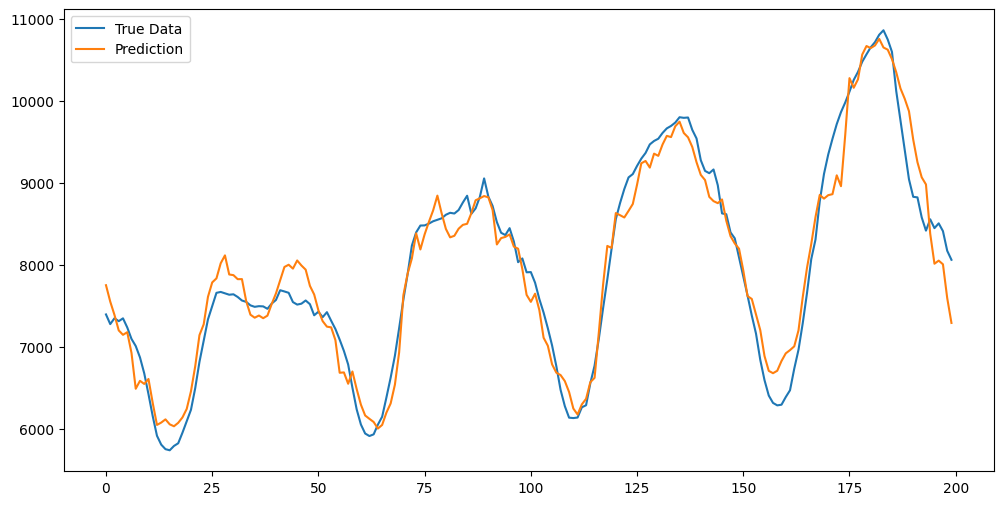

In [ ]:
test(model,X_test,Y_test,data_df_combined_clean)